### DataLoader 

In [1]:
from scripts.datasets import CaptionsDataset
import matplotlib.pyplot as plt 
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import json 
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def convert_idx_to_word(idx, dic):
    for key, val in dic.items(): 
        if idx == val:
            return key 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The 0 th image...
<start> the man with pierced ears is wearing glasses and an orange hat <end> <pad> <pad> <pad> <pad> 
The 1 th image...
<start> a black and white dog is running in a grassy garden surrounded by a white fence <end> 
The 2 th image...
<start> girl about to kick a piece of wood in half while karate instructor holds it <end> <pad> 
The 3 th image...
<start> five people wearing winter jackets and helmets stand in the snow with snowmobiles in the background <end> 
The 4 th image...
<start> two men on a rooftop while another man stands atop a ladder watching them <end> <pad> <pad> 
The 5 th image...
<start> a man photographs a woman in a pink dress and a <unk> of men in suits <end> 
The 6 th image...
<start> the people are quietly listening while the story of the ice cabin was <unk> to them <end> 
The 7 th image...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<start> a baseball player attempting to score a run before the catcher tags the player out <end> <pad> 
The 8 th image...
<start> a man stands on boards on top of a huge ladder <end> <pad> <pad> <pad> <pad> <pad> 
The 9 th image...
<start> man in bright yellow vest displays bicycle safety information on street <end> <pad> <pad> <pad> <pad> <pad> 


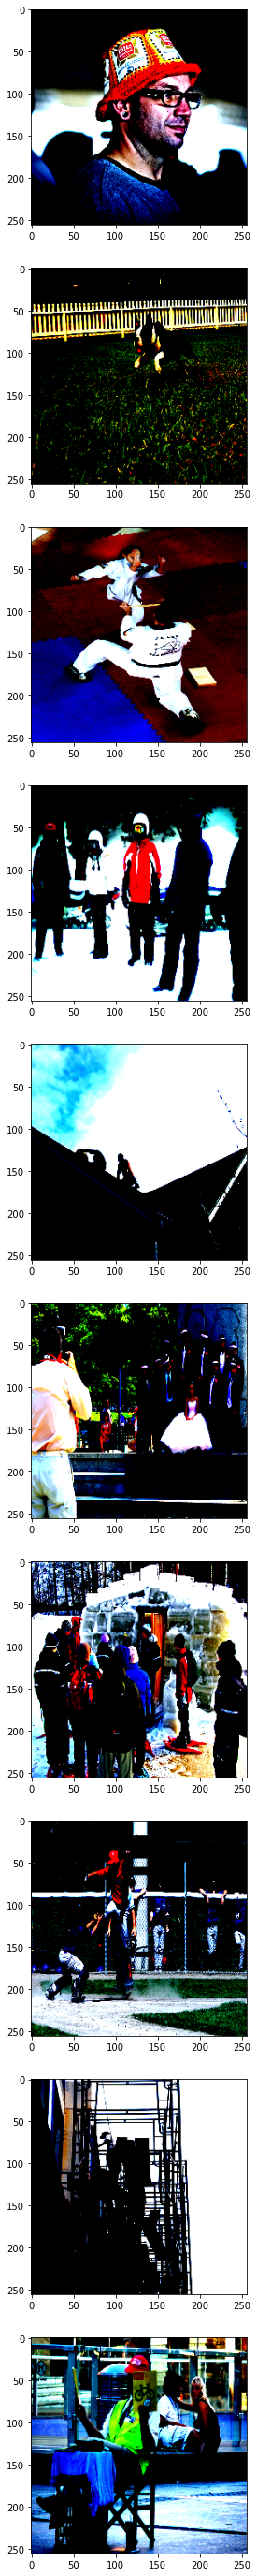

In [4]:
SPLIT = 'TEST'
DATA_PATH = '/home/ec2-user/SageMaker/efs/200005/processed_flickr30k'
word_dict = '/home/ec2-user/SageMaker/efs/200005/processed_flickr30k/WORDMAP_flickr30k_5_cap_per_img_5_min_word_freq.json'
with open(word_dict, 'r') as f:
    dic = json.load(f)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

caption_dataset = CaptionsDataset(data_path=DATA_PATH, split=SPLIT, transform=transforms.Compose([transforms.ToTensor(), normalize]))
display_num = 10 
fig = plt.figure(figsize=(50, 50))

for i in range(display_num):
    image, caption, caplen = caption_dataset[i*5]
    for idx in caption:
        print(f"{convert_idx_to_word(idx, dic)}", end=" ")
    print() 
    resized_image = np.transpose(image, (1, 2, 0))
    fig.add_subplot(display_num, 1, i+1)
    plt.imshow(resized_image)
plt.show() 